# EWT

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten, Input
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.fft import fft, ifft

2024-11-13 09:21:56.403073: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [622]:
%run utils.ipynb

In [143]:
df_ori = load_data('df_actual_22_24_cleaned')

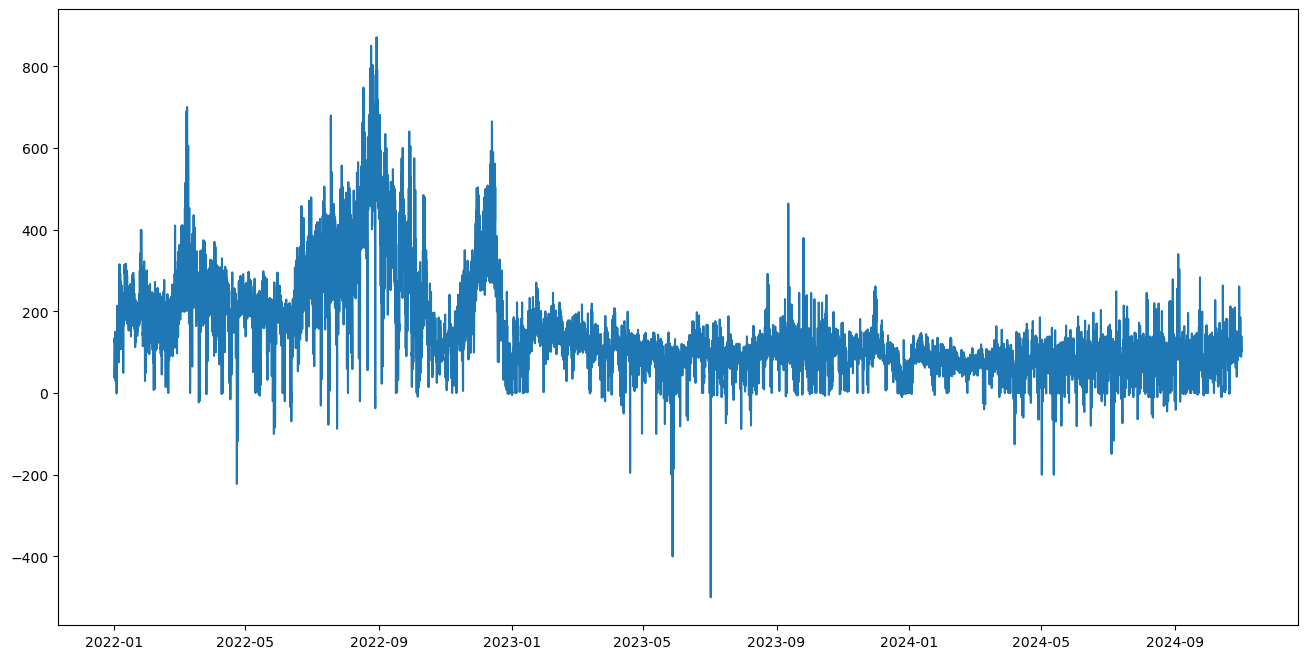

In [144]:
fig= plt.subplots(figsize=(16, 8))
plt.plot(df_ori['price'], label="Original Signal", linewidth=1.5)

In [145]:
# features = ['price', 'actual_solar', 'actual_wind_onshore', 'actual_wind_offshore', 'actual_fossil_gas', 'actual_fossil_hard_coal']
features = ['price'] 

In [146]:
df = df_ori.loc['2022': '2024',  features]

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24840 entries, 2022-01-01 01:00:00 to 2024-11-01 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   24840 non-null  float64
dtypes: float64(1)
memory usage: 388.1 KB


In [148]:
train_df = df.loc['2022': '2023']
test_df = df.loc['2024': '2024']

In [149]:
df.shape

(24840, 1)

## EWT decompose

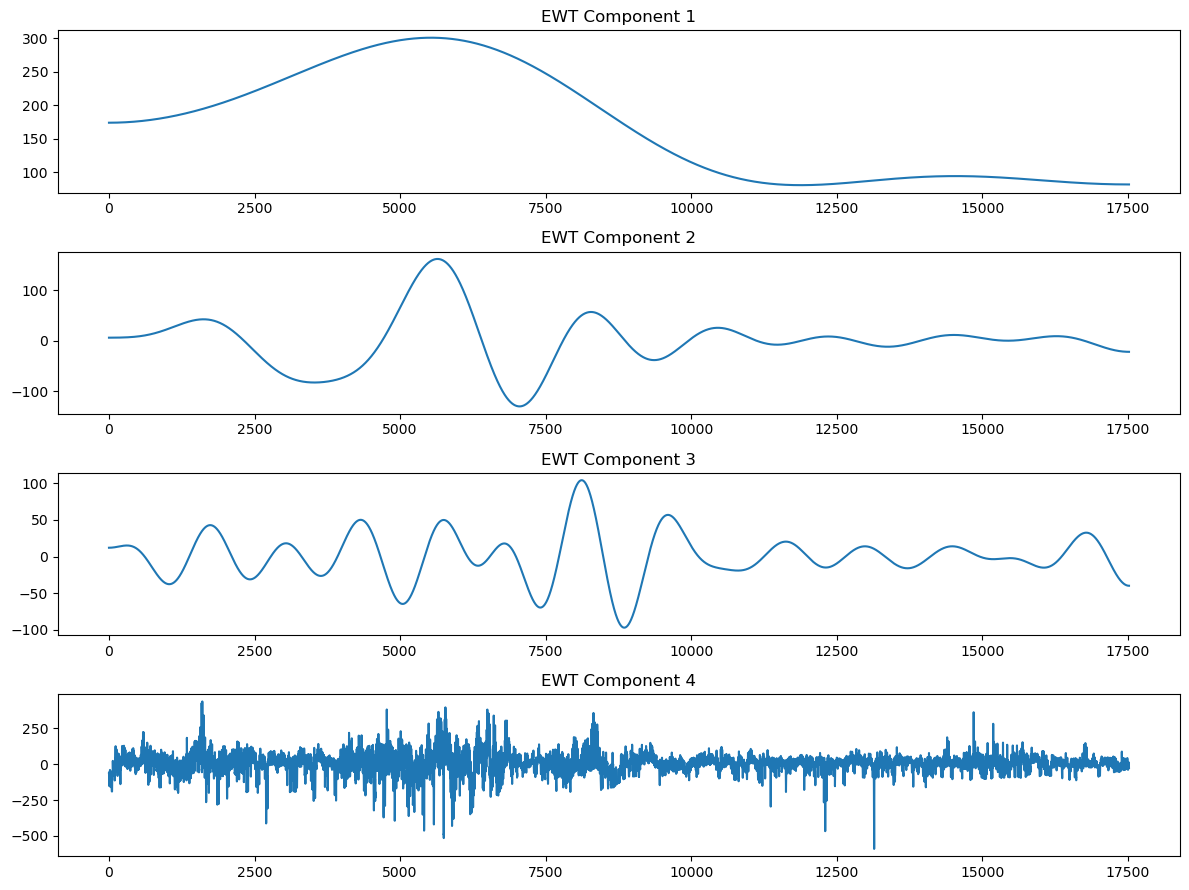

In [502]:
sig_train, comps_train = ewt_decompose(train_df['price'], 4, plot= True, lengthFilter= 6, sigmaFilter = 2)

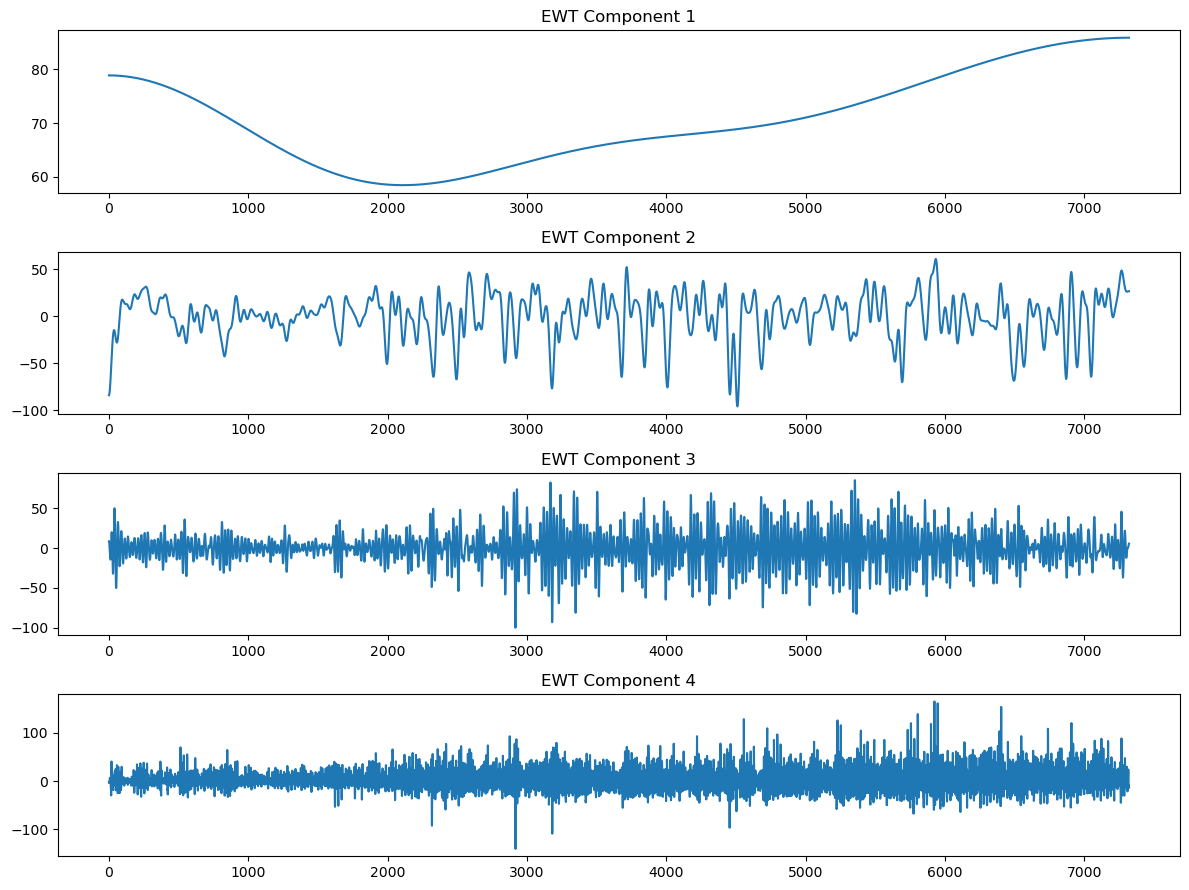

In [504]:
sig_test, comps_test = ewt_decompose(test_df['price'], 4, plot= True, lengthFilter= 6, sigmaFilter = 2)

## Function

Mean Absolute Error (MAE): 13.10
Root Mean Squared Error (RMSE): 17.43
Symmetric Mean Absolute Percentage Error (sMAPE): 17.66


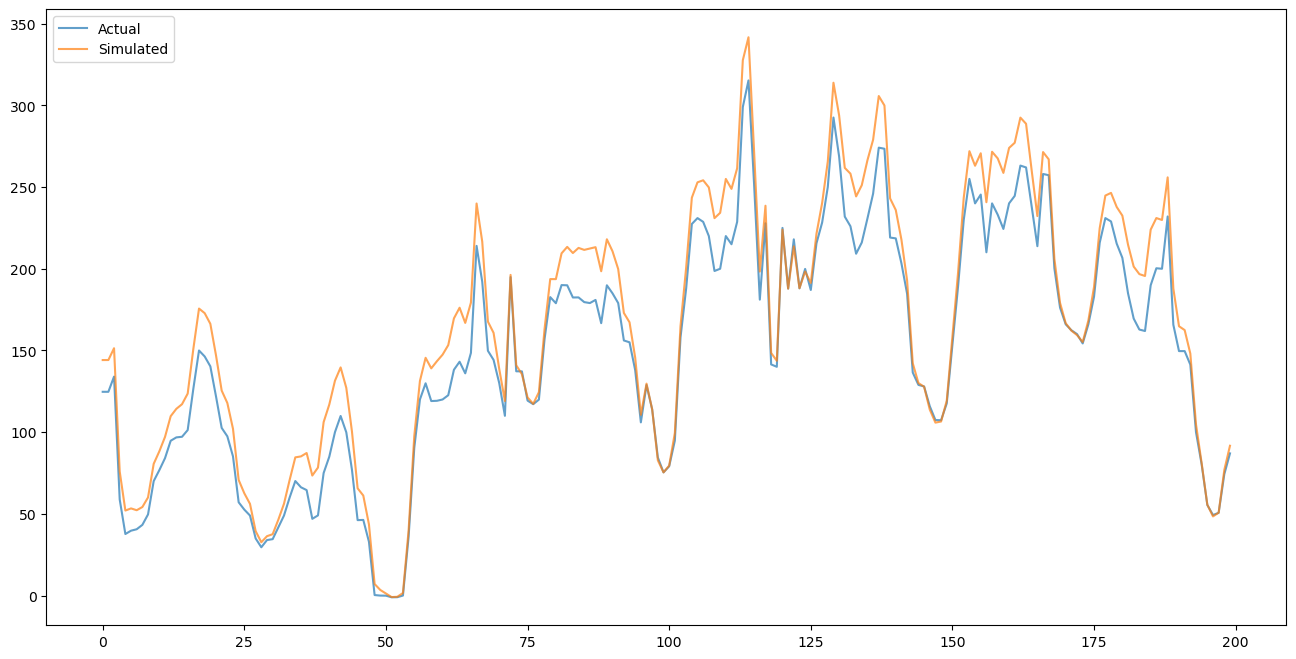

In [671]:
sig_train, comps_train = ewt_decompose(train_df['price'], 4, plot= False, reg= 'gaussian',lengthFilter= 10, sigmaFilter = 5)
eva_s(train_df['price'].to_numpy(), sig_train)
fig, ax= plt.subplots(figsize=(16, 8))
plt.plot(train_df['price'].to_numpy()[:200], label = 'Actual',alpha = 0.7)
plt.plot(sig_train[:200], label = 'Simulated', alpha = 0.7)
ax.legend(loc=2)

Mean Absolute Error (MAE): 2.79
Root Mean Squared Error (RMSE): 3.67
Symmetric Mean Absolute Percentage Error (sMAPE): 16.20


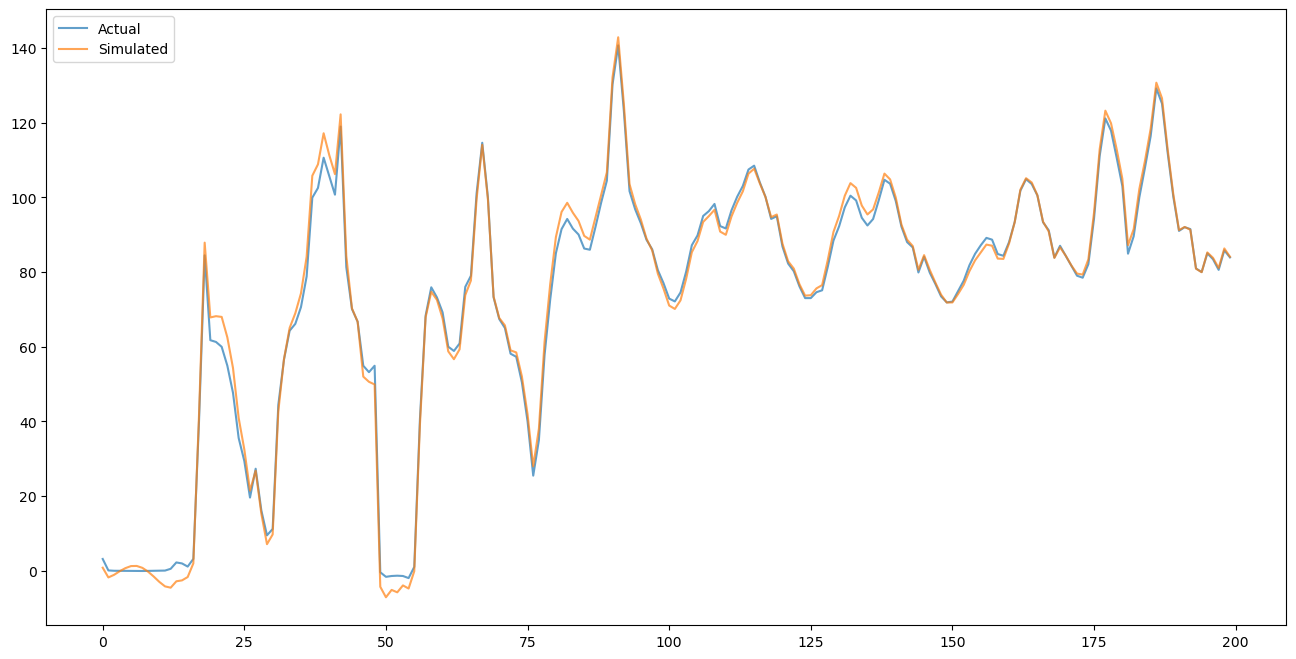

In [672]:
sig_test, comps_test = ewt_decompose(test_df['price'], 4, plot= False, reg= 'gaussian', lengthFilter= 10, sigmaFilter = 5)
fig, ax= plt.subplots(figsize=(16, 8))
eva_s(test_df['price'].to_numpy(), sig_test)
plt.plot(test_df['price'].to_numpy()[:200], label = 'Actual',alpha = 0.7)
plt.plot(sig_test[:200], label = 'Simulated',alpha = 0.7)
ax.legend(loc=2)

In [673]:
comps_train.shape[1]

4

In [674]:
def lstm_model_ewt(train_data, test_data):
    # Step 3: Normalize each component separately
    scaler = MinMaxScaler()
    # train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
    # test_scaled = scaler.transform(test_data.reshape(-1, 1))
    
    train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
    test_scaled = scaler.transform(test_data.reshape(-1, 1))
    
    # train_scaled = train_data.reshape(-1, 1)
    
    def create_seq(data, seq_length=24):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i + seq_length, :])  # Previous `window_size` steps across all components
            y.append(data[i + seq_length, 0])
    
        return np.array(X), np.array(y)
    
    X_train, y_train = create_seq(train_scaled, 168)
    X_test, y_test = create_seq(test_scaled, 168)# Step 5: Define the LSTM model
    
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units=64, return_sequences=True),
        LSTM(units=32, return_sequences=False),
        Dense(units=1)
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    model.summary()

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=32)
    
    y_pred = model.predict(X_test)
    # Predict
    y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    
    mae, rsme, mape = eva_s(y_test_rescaled, y_pred_rescaled)

    y_test_preds = [y_test_rescaled,y_pred_rescaled]
    performance = [mae, rsme, mape]

    return model, y_test_preds, performance
    
    # return model

In [675]:
models = []
test_preds =[]
metrics = []
for i in range(comps_train.shape[1]):
# for i in range(1):
    print('components:',i)
    train_data = comps_train[:,i]
    test_data = comps_test[:,i]
    model, y_test_preds, performance = lstm_model_ewt(train_data, test_data)
    models.append(model)
    test_preds.append(y_test_preds)
    metrics.append(performance)
    

components: 0


Model: "sequential_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_150 (LSTM)                 │ (None, 168, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_151 (LSTM)                 │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 38s 67ms/step - loss: 0.0082
Epoch 2/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 37s 67ms/step - loss: 7.8539e-06
Epoch 3/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 37s 69ms/step - loss: 1.8755e-06
Epoch 4/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 39s 72ms/step - loss: 2.1997e-06
Epoch 5/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 39s 71ms/step - loss: 3.8813e-06
Epoch 6/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 39s 71ms/step - loss: 8.7978e-06
Epoch 7/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 39s 72ms/step - loss: 3.8252e-06
Epoch 8/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 39s 72ms/step - loss: 5.5760e-06
Epoch 9/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 40s 74ms/step - loss: 1.1676e-05
Epoch 10/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 40s 74ms/step - loss: 3.5013e-06
Epoch 11/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 39s 72ms/step - loss: 5.8205e-06
Epoch 12/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 39s 72ms/step - loss: 2.5580e-06
Epoch 13/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 40s 74ms/step - loss: 3.3597e-06
Epoch 14/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 41s 75ms/s

Model: "sequential_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_152 (LSTM)                 │ (None, 168, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_153 (LSTM)                 │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 39s 68ms/step - loss: 0.0065
Epoch 2/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 37s 69ms/step - loss: 1.4661e-05
Epoch 3/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 40s 73ms/step - loss: 1.0133e-05
Epoch 4/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 38s 70ms/step - loss: 8.8715e-06
Epoch 5/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 38s 71ms/step - loss: 4.9166e-06
Epoch 6/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 38s 70ms/step - loss: 5.4823e-06
Epoch 7/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 37s 69ms/step - loss: 3.4645e-06
Epoch 8/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 37s 69ms/step - loss: 5.8243e-06
Epoch 9/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 40s 73ms/step - loss: 8.5337e-06
Epoch 10/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 40s 73ms/step - loss: 5.7764e-06
Epoch 11/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 43s 80ms/step - loss: 5.2300e-06
Epoch 12/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - loss: 5.1657e-06
Epoch 13/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 42s 78ms/step - loss: 5.0654e-06
Epoch 14/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 42s 77ms/s

Model: "sequential_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_154 (LSTM)                 │ (None, 168, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_155 (LSTM)                 │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - loss: 0.0128
Epoch 2/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 43s 78ms/step - loss: 2.3357e-04
Epoch 3/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 42s 77ms/step - loss: 5.1292e-05
Epoch 4/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 40s 74ms/step - loss: 3.5541e-05
Epoch 5/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 39s 71ms/step - loss: 2.0828e-05
Epoch 6/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 40s 74ms/step - loss: 1.8364e-05
Epoch 7/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 53s 97ms/step - loss: 1.5319e-05
Epoch 8/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 40s 74ms/step - loss: 1.4938e-05
Epoch 9/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 40s 74ms/step - loss: 7.7656e-06
Epoch 10/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 40s 74ms/step - loss: 8.8383e-06
Epoch 11/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 40s 73ms/step - loss: 5.9789e-06
Epoch 12/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 39s 71ms/step - loss: 7.3216e-06
Epoch 13/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 41s 76ms/step - loss: 6.0610e-06
Epoch 14/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 43s 78ms/s

Model: "sequential_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_156 (LSTM)                 │ (None, 168, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_157 (LSTM)                 │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 44s 77ms/step - loss: 0.0211
Epoch 2/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 46s 85ms/step - loss: 0.0035
Epoch 3/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 41s 76ms/step - loss: 0.0017
Epoch 4/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 42s 78ms/step - loss: 0.0011
Epoch 5/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 42s 77ms/step - loss: 0.0010
Epoch 6/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 42s 78ms/step - loss: 9.0364e-04
Epoch 7/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - loss: 9.6683e-04
Epoch 8/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 44s 81ms/step - loss: 0.0010
Epoch 9/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 57s 105ms/step - loss: 9.4420e-04
Epoch 10/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 53s 98ms/step - loss: 8.6002e-04
Epoch 11/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 50s 93ms/step - loss: 8.9840e-04
Epoch 12/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 46s 85ms/step - loss: 8.6539e-04
Epoch 13/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 44s 80ms/step - loss: 8.5144e-04
Epoch 14/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 45s 82ms/step - loss: 8.3131e

In [678]:
test_preds_n = np.asarray(test_preds)

In [679]:
y_t = test_preds_n[:,0,:,:]
y_p = test_preds_n[:,1,:,:]

In [680]:
y_t_sum = np.sum(y_t, axis=0).reshape(-1,1)
y_p_sum = np.sum(y_p, axis=0).reshape(-1,1)

In [681]:
y_t_sum[:3]

array([[83.76324034],
       [86.61641276],
       [84.37018227]])

In [682]:
test_comp_sum = np.sum(comps_test, axis=a).reshape(-1,1)

In [683]:
test_comp_sum.shape

(7321, 1)

In [684]:
test_comp_sum[24: 30]

array([[40.91672201],
       [32.47538498],
       [21.44241291],
       [26.78783376],
       [15.30939255],
       [ 7.12800616]])

In [690]:
y_p_sum.shape

(7153, 1)

In [689]:
test_df['price'][168:].shape

(7153,)

In [687]:
eva_s(y_t_sum, y_p_sum)

Mean Absolute Error (MAE): 11.29
Root Mean Squared Error (RMSE): 14.89
Symmetric Mean Absolute Percentage Error (sMAPE): 28.78


(11.286964317394759, 14.893229912996858, 28.776794220767776)

In [676]:
eva_s(test_df['price'][168:].to_numpy().reshape(-1,1), y_p_sum)

ValueError: Found input variables with inconsistent numbers of samples: [7153, 7273]

In [ ]:
test_df['price'][24: 30]

In [ ]:
compare_preds(test_df['price'][24:].to_numpy().reshape(-1,1)[:200], y_p_sum[:200])

## Data Processing

### EWT

In [416]:
df['price'].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 24840 entries, 2022-01-01 01:00:00 to 2024-11-01 00:00:00
Series name: price
Non-Null Count  Dtype  
--------------  -----  
24840 non-null  float64
dtypes: float64(1)
memory usage: 904.2 KB


In [76]:
ewt.shape

(24841, 5)

In [ ]:

def ewt_decompose(signal, K):
    # Perform Fourier Transform
    fourier_transform = fft(signal)
    components = []
    freq_range = np.linspace(0, np.pi, K + 1)
    
    # Define filters and extract components
    for i in range(K):
        filter_mask = np.zeros_like(fourier_transform)
        left_boundary = freq_range[i]
        right_boundary = freq_range[i + 1]
        
        for j in range(len(fourier_transform)):
            frequency = j * np.pi / len(fourier_transform)
            if left_boundary <= frequency <= right_boundary:
                filter_mask[j] = 1
        
        # Apply filter and inverse FFT
        component_fft = fourier_transform * filter_mask
        component_ifft = ifft(component_fft).real  # Convert back to time domain
        components.append(component_ifft)
    
    return np.array(components).T  # Shape: (t

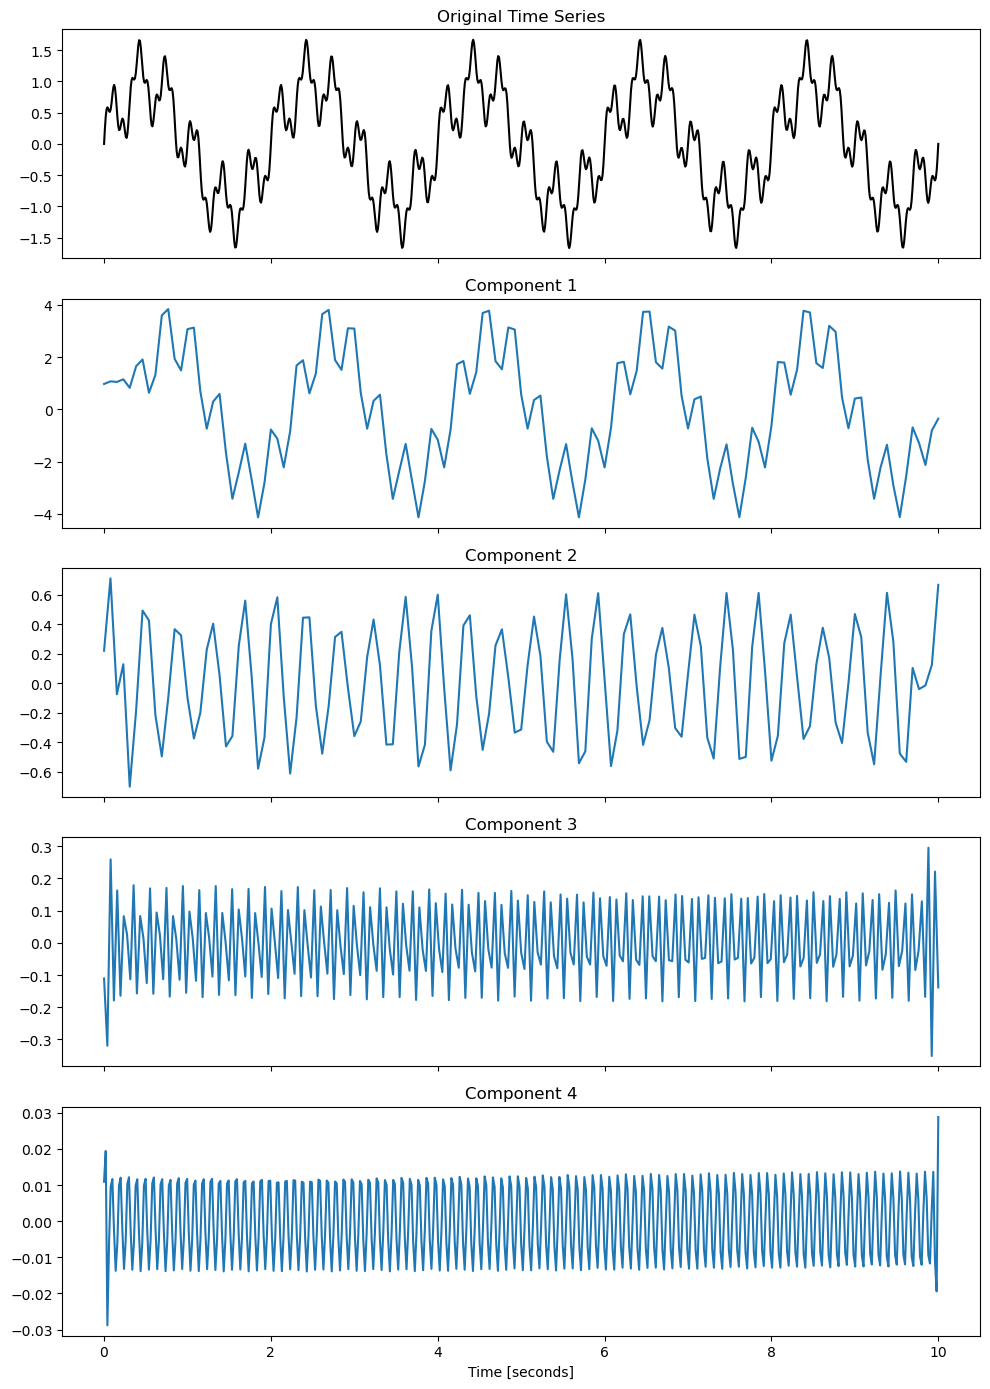

In [37]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Simulate or load a sample time series
time = np.linspace(0, 10, 1000)
series = np.sin(2 * np.pi * 0.5 * time) + 0.5 * np.sin(2 * np.pi * 3 * time) + 0.2 * np.sin(2 * np.pi * 10 * time)

# Perform discrete wavelet decomposition with 6 levels
wavelet = 'db4'  # Daubechies wavelet, you can choose others like 'haar', 'coif', etc.
coeffs = pywt.wavedec(series, wavelet, level=3)

# Plot original signal and decomposed components
fig, axs = plt.subplots(len(coeffs) + 1, 1, figsize=(10, 14), sharex=True)

# Plot original time series
axs[0].plot(time, series, color='black')
axs[0].set_title("Original Time Series")

# Plot each decomposed component
for i, coeff in enumerate(coeffs):
    axs[i + 1].plot(np.linspace(0, 10, len(coeff)), coeff)
    axs[i + 1].set_title(f"Component {i+1}")

plt.xlabel("Time [seconds]")
plt.tight_layout()
plt.show()


In [77]:
import pywt
# Define the features to decompose
features_to_decompose = features
# features_to_decompose = ['price']

# Function to apply wavelet decomposition to each feature
def wavelet_decompose(series, wavelet='db1', level=3):
    coeffs = pywt.wavedec(series, wavelet, level=level)  # Decompose signal into frequency components
    decomposed_data = pd.DataFrame(coeffs).T  # Convert to DataFrame
    decomposed_data.columns = [f'{series.name}_wavelet_{i}' for i in range(len(coeffs))]
    return decomposed_data

# Apply wavelet decomposition to each feature and store the decomposed components
decomposed_features = []
for feature in features_to_decompose:
    decomposed = wavelet_decompose(df[feature], wavelet='db4', level=5)
    decomposed.index = df.index[:len(decomposed)]  # Align indices with the original data
    decomposed_features.append(decomposed)

# Concatenate decomposed features with the original data
decomposed_data = pd.concat(decomposed_features, axis=1)
data_dc = pd.concat([df, decomposed_data], axis=1)

In [78]:
data_dc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24840 entries, 2022-01-01 01:00:00 to 2024-11-01 00:00:00
Freq: h
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   price                              24840 non-null  float64
 1   actual_solar                       24840 non-null  int64  
 2   actual_wind_onshore                24840 non-null  int64  
 3   actual_wind_offshore               24840 non-null  int64  
 4   actual_fossil_gas                  24840 non-null  int64  
 5   actual_fossil_hard_coal            24840 non-null  int64  
 6   price_wavelet_0                    783 non-null    float64
 7   price_wavelet_1                    783 non-null    float64
 8   price_wavelet_2                    1559 non-null   float64
 9   price_wavelet_3                    3111 non-null   float64
 10  price_wavelet_4                    6215 non-null   float64
 11  price_wavel

In [80]:
df = data_dc.copy()

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24840 entries, 2022-01-01 01:00:00 to 2024-11-01 00:00:00
Freq: h
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   price                              24840 non-null  float64
 1   actual_solar                       24840 non-null  int64  
 2   actual_wind_onshore                24840 non-null  int64  
 3   actual_wind_offshore               24840 non-null  int64  
 4   actual_fossil_gas                  24840 non-null  int64  
 5   actual_fossil_hard_coal            24840 non-null  int64  
 6   price_wavelet_0                    783 non-null    float64
 7   price_wavelet_1                    783 non-null    float64
 8   price_wavelet_2                    1559 non-null   float64
 9   price_wavelet_3                    3111 non-null   float64
 10  price_wavelet_4                    6215 non-null   float64
 11  price_wavel

In [82]:
train_df = df['2022': '2023']
test_df = df['2024': '2024']

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df[features])
test_scaled = scaler.transform(test_df[features])

# Step 3: Create Sequences Function
def create_sequences_2(data, seq_length=24, target_column='price'):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length].values)  # Include all features in X
        y.append(data[target_column].iloc[i+seq_length])  # Target is still the original 'price'
    return np.array(X), np.array(y)

# Convert scaled data to DataFrame for consistency in `create_sequences` function
train_scaled_df = pd.DataFrame(train_scaled, columns=features)
test_scaled_df = pd.DataFrame(test_scaled, columns=features)

# Generate sequences for LSTM model
X_train, y_train = create_sequences_2(train_scaled_df)
X_test, y_test = create_sequences_2(test_scaled_df)

# Step 4: Build the LSTM Model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
# model.add(LSTM(50, activation='relu', return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(1))  # Output layer for regression


# multivariate_lstm = tf.keras.models.Sequential([
#     LSTM(100, input_shape=input_shape, 
#          return_sequences=True),
#     Flatten(),
#     Dense(200, activation='relu'),
#     Dropout(0.1),
#     Dense(1)
# ])


model.compile(optimizer='adam', loss='mean_squared_error')
# loss =tf. keras.losses.MeanSquaredError()
# metric = [tf.keras.metrics.RootMeanSquaredError()]
# optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)
# multivariate_lstm.compile(loss=loss,
#                           optimizer=optimizer,
#                           metrics=metric)

# Early stopping can be omitted if not needed; here, it’s kept with training loss monitoring.
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Fit the model without validation data
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Step 6: Evaluate the Model on the Test Set
# Calculate the test loss
test_loss = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")

y_pred = model.predict(X_test)

eva(y_test, y_pred, X_test)

"""
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price                 24816 non-null  float64
 1   solar                 24816 non-null  int64  
 2   wind_onshore          24816 non-null  int64  
 3   wind_offshore         24816 non-null  int64  
 4   total_load            24816 non-null  int64  
 5   price_lag_1           24816 non-null  float64
 6   price_lag_2           24816 non-null  float64
 7   price_lag_25          24816 non-null  float64
 8   wind_onshore_lag_1    24816 non-null  float64
 9   wind_onshore_lag_2    24816 non-null  float64
 10  wind_onshore_lag_25   24816 non-null  float64
 11  wind_offshore_lag_1   24816 non-null  float64
 12  wind_offshore_lag_2   24816 non-null  float64
 13  wind_offshore_lag_25  24816 non-null  float64
 14  solar_lag_1           24816 non-null  float64
 15  solar_lag_2           24816 non-null  float64
 16  solar_lag_25          24816 non-null  float64
 17  total_load_lag_1      24816 non-null  float64
 18  total_load_lag_2      24816 non-null  float64
 19  total_load_lag_25     24816 non-null  float64
 20  price_moving_avg_8    24816 non-null  float64
 21  price_moving_avg_24   24816 non-null  float64
 """

Epoch 1/50


/Users/libin/anaconda3/envs/th/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0106
Epoch 2/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0015
Epoch 3/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0013
Epoch 4/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0011
Epoch 5/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 9.3564e-04
Epoch 6/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 8.0272e-04
Epoch 7/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 6.8073e-04
Epoch 8/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 5.9453e-04
Epoch 9/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 5.2029e-04
Epoch 10/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 5.1508e-04
Epoch 11/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 4.9062e-04
Epoch 12/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 4.5487e-04
Epoch 13/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 4.1502e-04
Epoch 14/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 4.4618e-04
Epoch 15/50
54

'\n #   Column                Non-Null Count  Dtype  \n---  ------                --------------  -----  \n 0   price                 24816 non-null  float64\n 1   solar                 24816 non-null  int64  \n 2   wind_onshore          24816 non-null  int64  \n 3   wind_offshore         24816 non-null  int64  \n 4   total_load            24816 non-null  int64  \n 5   price_lag_1           24816 non-null  float64\n 6   price_lag_2           24816 non-null  float64\n 7   price_lag_25          24816 non-null  float64\n 8   wind_onshore_lag_1    24816 non-null  float64\n 9   wind_onshore_lag_2    24816 non-null  float64\n 10  wind_onshore_lag_25   24816 non-null  float64\n 11  wind_offshore_lag_1   24816 non-null  float64\n 12  wind_offshore_lag_2   24816 non-null  float64\n 13  wind_offshore_lag_25  24816 non-null  float64\n 14  solar_lag_1           24816 non-null  float64\n 15  solar_lag_2           24816 non-null  float64\n 16  solar_lag_25          24816 non-null  float64\n 17  tota

In [61]:
eva(y_test, y_pred, X_test)

Mean Absolute Error (MAE): 12.89
Root Mean Squared Error (RMSE): 16.90
Symmetric Mean Absolute Percentage Error (sMAPE): 31.61


(array([ 35.55,  29.39,  19.6 , ..., 107.  , 107.4 , 101.72]),
 array([ 53.34496671,  43.85301614,  36.3666288 , ..., 114.52259228,
        110.17654473, 109.66253871]))

# Pure LSTM

In [4]:
df = df_ori.loc['2022': '2024',  ['price']]
train_df = df['2022': '2023']
test_df = df['2024': '2024']

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2022-01-01 00:00:00 to 2023-12-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   17520 non-null  float64
dtypes: float64(1)
memory usage: 273.8 KB


In [ ]:
# Assuming your DataFrame is named 'df' and has a DatetimeIndex on 'price' column

# Define the training and test periods based on date
# train_data = df['2022':'2023']  # Selects all data in 2022 and 2023
# test_data = df['2024']           # Selects all data in 2024

# Scale the data to [0, 1] range using only the training data to avoid data leakage
# from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_df['price_scaled'] = scaler.fit_transform(train_df[['price']])
test_df['price_scaled'] = scaler.transform(test_df[['price']])

# Prepare the sequences for LSTM
sequence_length = 24  # Number of previous steps to use for prediction
X_train, y_train = [], []
X_test, y_test = [], []

# Prepare training sequences
for i in range(len(train_df) - sequence_length):
    X_train.append(train_df['price_scaled'].values[i:i + sequence_length])
    y_train.append(train_df['price_scaled'].values[i + sequence_length])

# Prepare test sequences
for i in range(len(test_df) - sequence_length):
    X_test.append(test_df['price_scaled'].values[i:i + sequence_length])
    y_test.append(test_df['price_scaled'].values[i + sequence_length])

# Convert lists to arrays and reshape for LSTM input
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on test data
y_preds = model.predict(X_test)

# # Inverse scale the predictions to get them back in the original scale
# y_preds = scaler.inverse_transform(test_predictions)
# y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# # Display the first 10 test predictions vs actual values
# for i in range(10):
#     print(f"Predicted: {test_predictions[i][0]}, Actual: {y_test_original[i][0]}")

eva(y_test, y_preds, X_test)

In [7]:
import pywt
import numpy as np
import matplotlib.pyplot as plt


In [8]:
p= df.loc['2022-01-01':'2022-03-31','price'].to_numpy()

In [9]:
# Example time series data
# time_series = np.sin(np.linspace(0, 2 * np.pi, 100)) + 0.3 * np.random.normal(size=100)
time_series = p

# Decompose with DWT
wavelet = 'db6'  # Daubechies wavelet
coeffs = pywt.wavedec(time_series, wavelet)

# Apply thresholding (soft thresholding here)
sigma = np.std(coeffs[-1])  # Estimate noise level from the last detail level
threshold = sigma * np.sqrt(2 * np.log(len(time_series)))

# Threshold each detail coefficient except the approximation
coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]

# Reconstruct the denoised signal
denoised_series = pywt.waverec(coeffs, wavelet)


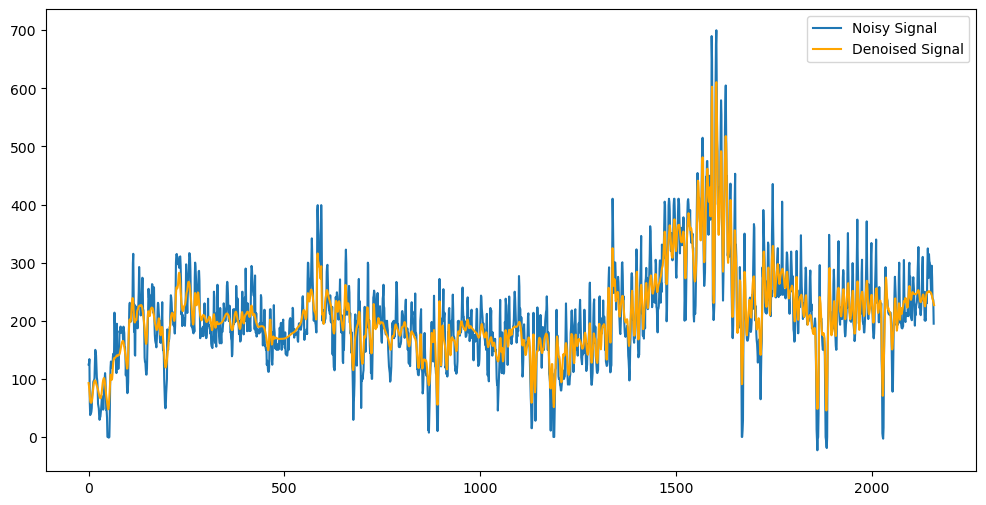

In [60]:
plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Noisy Signal')
plt.plot(denoised_series, label='Denoised Signal', color='orange')
plt.legend()
plt.show()


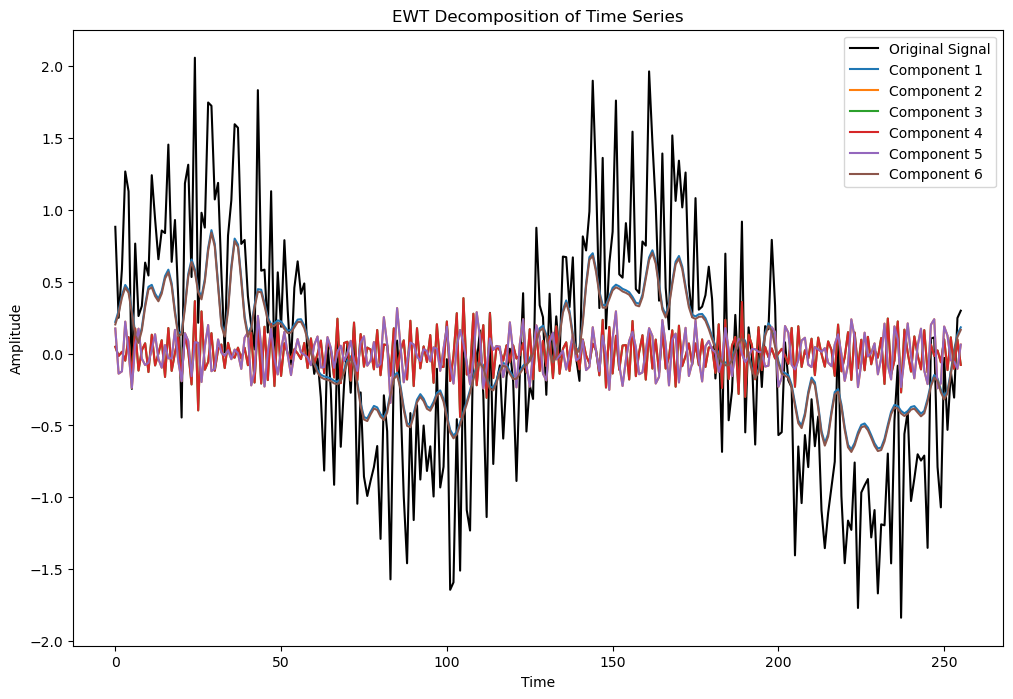

In [61]:
import numpy as np
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt

# Example signal generation (replace this with your actual data)
np.random.seed(0)
time_series = np.sin(2 * np.pi * np.arange(256) / 128) + 0.5 * np.random.randn(256)

# Step 1: Perform Fourier Transform on the signal
fourier_transform = fft(time_series)
fourier_magnitude = np.abs(fourier_transform)

# Step 2: Define boundaries in Fourier spectrum based on 'K' intervals
# We can divide the Fourier frequency range adaptively or using predefined intervals.
# For this example, I'll divide the Fourier spectrum into six intervals.
K = 6
freq_range = np.linspace(0, np.pi, K + 1)

# Step 3: Construct empirical wavelet filters based on boundaries
# Here, we approximate the wavelet filter design using the Littlewood-Paley approach.
filters = []
for i in range(K):
    filter_mask = np.zeros_like(fourier_transform)
    left_boundary = freq_range[i]
    right_boundary = freq_range[i + 1]
    
    for j in range(len(fourier_transform)):
        frequency = j * np.pi / len(fourier_transform)
        if left_boundary <= frequency <= right_boundary:
            filter_mask[j] = 1
    
    filters.append(filter_mask)

# Step 4: Apply filters to get modal components
components = []
for filter_mask in filters:
    component_fft = fourier_transform * filter_mask
    component_ifft = ifft(component_fft).real  # Inverse FFT to get time-domain signal
    components.append(component_ifft)

# Visualization of decomposed components
plt.figure(figsize=(12, 8))
plt.plot(time_series, label='Original Signal', color='black')
for i, component in enumerate(components):
    plt.plot(component, label=f'Component {i+1}')
plt.legend()
plt.title("EWT Decomposition of Time Series")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


Epoch 1/20


/Users/libin/anaconda3/envs/th/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0083
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0011
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 5.4575e-04
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 2.6162e-04
Epoch 5/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 1.9180e-04
Epoch 6/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.2900e-04
Epoch 7/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.1434e-04
Epoch 8/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 8.3573e-05
Epoch 9/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 5.3727e-05
Epoch 10/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.4644e-05
Epoch 11/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 2.8638e-05
Epoch 12/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.9100e-05
Epoch 13/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.4553e-05
Epoch 14/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.5371e-05
Epoch 15/20
547/547 

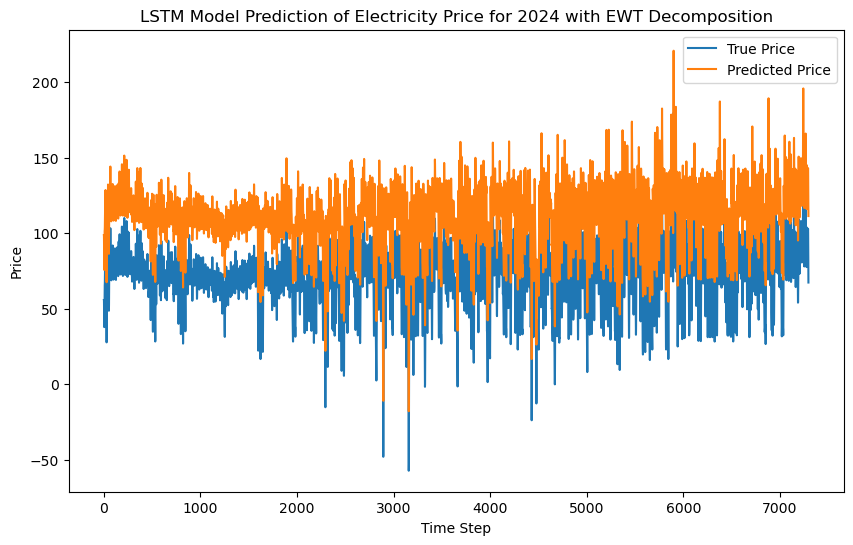

Mean Absolute Error (MAE): 39.98
Root Mean Squared Error (RMSE): 40.02
Symmetric Mean Absolute Percentage Error (sMAPE): 47.26


(array([55.712712  , 55.4170333 , 50.41425265, ..., 92.44477561,
        80.64908668, 67.29475069]),
 array([ 98.76711575,  97.68372168,  89.47061613, ..., 132.64357246,
        122.4836837 , 111.32450041]))

In [10]:
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft

# Assume `df` is your dataframe with a datetime index and 'price' column
# Example: df = pd.DataFrame({'price': price_data}, index=date_range)

# Step 1: Split data into train and test sets
train_data = df.loc['2022':'2023', 'price'].values
test_data = df.loc['2024', 'price'].values

# Function to perform EWT decomposition
def ewt_decompose(signal, K):
    # Perform Fourier Transform
    fourier_transform = fft(signal)
    components = []
    freq_range = np.linspace(0, np.pi, K + 1)
    
    # Define filters and extract components
    for i in range(K):
        filter_mask = np.zeros_like(fourier_transform)
        left_boundary = freq_range[i]
        right_boundary = freq_range[i + 1]
        
        for j in range(len(fourier_transform)):
            frequency = j * np.pi / len(fourier_transform)
            if left_boundary <= frequency <= right_boundary:
                filter_mask[j] = 1
        
        # Apply filter and inverse FFT
        component_fft = fourier_transform * filter_mask
        component_ifft = ifft(component_fft).real  # Convert back to time domain
        components.append(component_ifft)
    
    return np.array(components).T  # Shape: (time_steps, K components)

# Step 2: Apply EWT decomposition to both train and test data
K = 6  # Number of EWT components
train_components = ewt_decompose(train_data, K)
test_components = ewt_decompose(test_data, K)

# Step 3: Normalize each component separately
scaler = MinMaxScaler()
# train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
# test_scaled = scaler.transform(test_data.reshape(-1, 1))

train_scaled = scaler.fit_transform(train_components)
test_scaled = scaler.transform(test_components)

# Step 4: Prepare sequences with a rolling window (e.g., window_size = 24)
window_size = 24
X_train, y_train = [], []
for i in range(len(train_scaled) - window_size):
    X_train.append(train_scaled[i:i + window_size, :])  # Previous `window_size` steps across all components
    y_train.append(train_scaled[i + window_size, 0])    # Predicting the first component (target variable)

X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(len(test_scaled) - window_size):
    X_test.append(test_scaled[i:i + window_size, :])
    y_test.append(test_scaled[i + window_size, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Step 5: Define the LSTM model
model = Sequential([
    LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model without validation
history = model.fit(X_train, y_train, epochs=20, batch_size=32)

# Step 7: Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predictions
y_pred_rescaled = scaler.inverse_transform(
    np.concatenate([y_pred, np.zeros((y_pred.shape[0], train_components.shape[1]-1))], axis=1)
)[:, 0]
y_test_rescaled = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], train_components.shape[1]-1))], axis=1)
)[:, 0]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='True Price')
plt.plot(y_pred_rescaled, label='Predicted Price')
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.title("LSTM Model Prediction of Electricity Price for 2024 with EWT Decomposition")
plt.legend()
plt.show()

eva(y_test, y_pred, X_test)

In [66]:
112.88 - 55.71

57.169999999999995

In [67]:
110.52-55.41

55.11

In [73]:
y_pred[:5 ]

array([[0.4228436 ],
       [0.41942695],
       [0.40687814],
       [0.39333782],
       [0.38913003]], dtype=float32)

In [84]:
eva(y_test, y_pred - 0.08, X_test)

Mean Absolute Error (MAE): 2.37
Root Mean Squared Error (RMSE): 2.85
Symmetric Mean Absolute Percentage Error (sMAPE): 4.20


(array([55.712712  , 55.4170333 , 50.41425265, ..., 92.44477561,
        80.64908668, 67.29475069]),
 array([57.59786144, 55.23677809, 46.56491873, ..., 89.87108064,
        80.37097621, 68.2021416 ]))

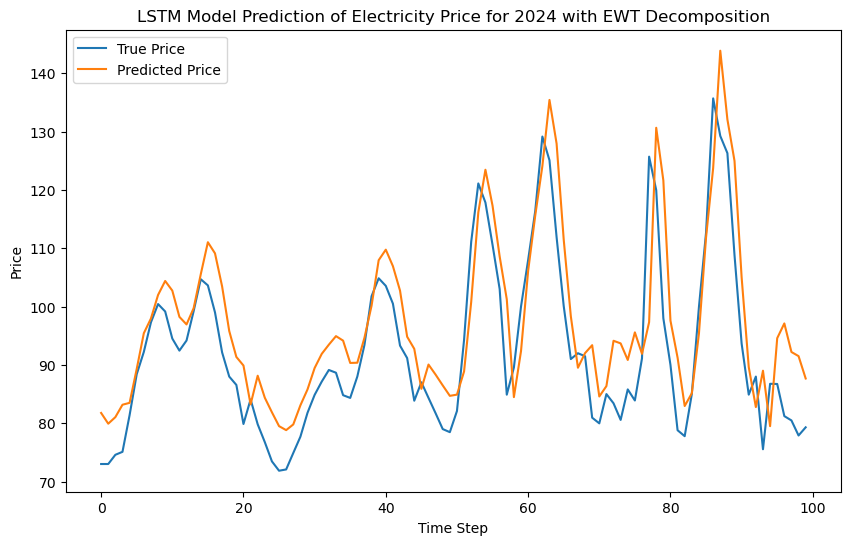

In [91]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled[100:200], label='True Price')
plt.plot(y_pred_rescaled[100:200], label='Predicted Price')
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.title("LSTM Model Prediction of Electricity Price for 2024 with EWT Decomposition")
plt.legend()
plt.show()



In [93]:
train_components[:5]

array([[ 1.30844080e+02,  4.06831463e+00,  1.18777714e+01,
         1.18777714e+01,  4.06831463e+00, -3.80362525e+01],
       [ 1.41235827e+02,  1.66270006e+01, -1.10726610e+01,
        -1.10726610e+01,  1.66270006e+01, -2.76445060e+01],
       [ 1.39699196e+02,  4.53861190e+00,  7.20235806e+00,
         7.20235806e+00,  4.53861190e+00, -2.91811364e+01],
       [ 1.27889776e+02, -1.12273602e+01, -2.82224906e+00,
        -2.82224906e+00, -1.12273602e+01, -4.09905572e+01],
       [ 1.12469969e+02, -9.26650692e+00,  7.17046452e-02,
         7.17046452e-02, -9.26650692e+00, -5.64103641e+01]])

## EWT

In [13]:
def ewt_decompose(signal, K):
    # Perform Fourier Transform
    fourier_transform = fft(signal)
    components = []
    freq_range = np.linspace(0, np.pi, K + 1)
    
    # Define filters and extract components
    for i in range(K):
        filter_mask = np.zeros_like(fourier_transform)
        left_boundary = freq_range[i]
        right_boundary = freq_range[i + 1]
        
        for j in range(len(fourier_transform)):
            frequency = j * np.pi / len(fourier_transform)
            if left_boundary <= frequency <= right_boundary:
                filter_mask[j] = 1
        
        # Apply filter and inverse FFT
        component_fft = fourier_transform * filter_mask
        component_ifft = ifft(component_fft).real  # Convert back to time domain
        components.append(component_ifft)
    
    return np.array(components).T  # Shape: (t

In [38]:
components = ewt_decompose(train_df['price'], 4)

In [43]:
components[:,0].shape

(17520,)

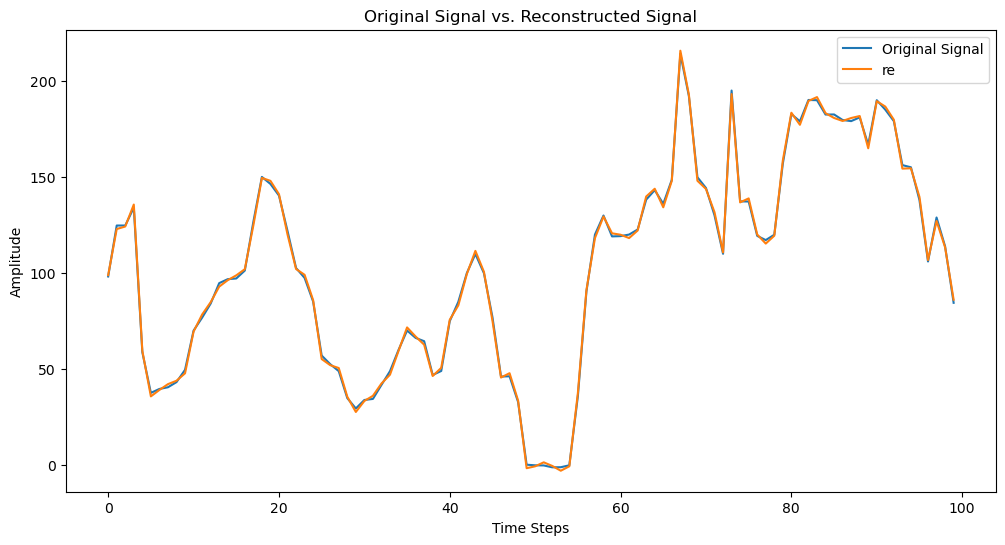

In [44]:
import matplotlib.pyplot as plt

# Assuming `signal` is the original signal and `reconstructed_signal` is the reconstructed one
plt.figure(figsize=(12, 6))
# plt.plot(components[:,0], label="Original Signal", linewidth=1.5)
plt.plot(train_df['price'].to_numpy()[:100], label="Original Signal", linewidth=1.5)
com = np.sum(components, axis=1)
plt.plot(com[:100], label="re", linewidth=1.5)
# plt.plot(components[0], label="Reconstructed Signal", linestyle='--', linewidth=1.5)
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.title("Original Signal vs. Reconstructed Signal")
plt.show()

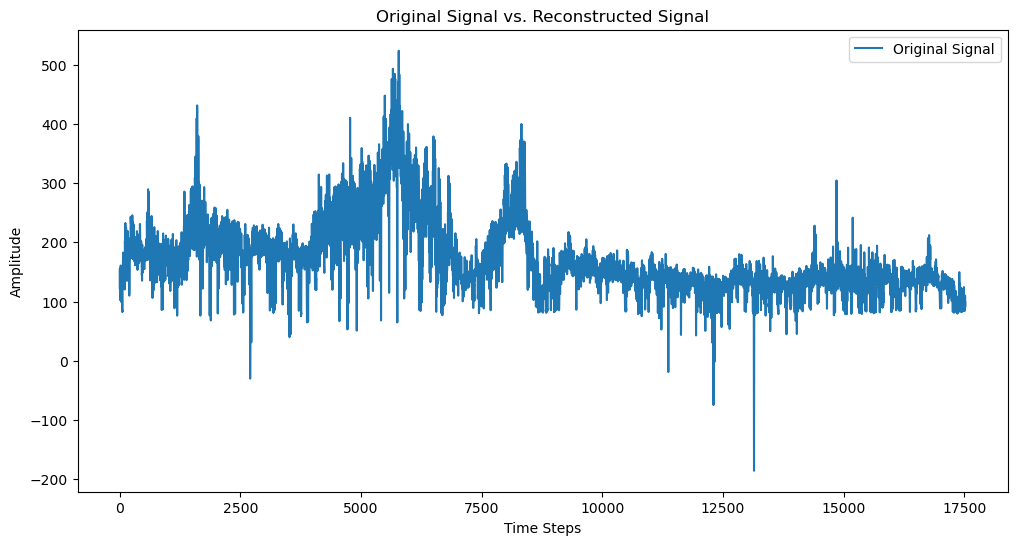

In [45]:
import matplotlib.pyplot as plt

# Assuming `signal` is the original signal and `reconstructed_signal` is the reconstructed one
plt.figure(figsize=(12, 6))
plt.plot(components[:,0], label="Original Signal", linewidth=1.5)
# plt.plot(train_df['price'], label="Original Signal", linewidth=1.5)

# plt.plot(components[0], label="Reconstructed Signal", linestyle='--', linewidth=1.5)
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.title("Original Signal vs. Reconstructed Signal")
plt.show()


In [46]:
e_df = components[:,0]
e_df = e_df.reshape(-1,1)

In [47]:
len_e_df = len(e_df)
train_prop = 0.8
train_data = e_df[:int(len_e_df * train_prop)]
test_data = e_df[int(len_e_df * train_prop):]

In [48]:
train_data.shape

(14016, 1)

In [49]:
test_data.shape

(3504, 1)

In [50]:

# Step 3: Normalize each component separately
scaler = MinMaxScaler()
# train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
# test_scaled = scaler.transform(test_data.reshape(-1, 1))

train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
test_scaled = scaler.transform(test_data)

# train_scaled = train_data.reshape(-1, 1)
# test_scaled = test_data

In [51]:
def create_seq(data, seq_length=24):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, :])  # Previous `window_size` steps across all components
        y.append(data[i + seq_length, 0])

    return np.array(X), np.array(y)

In [52]:
X_train, y_train = create_seq(train_scaled, 24)
X_test, y_test = create_seq(test_scaled, 24)

In [53]:
X_train.shape

(13992, 24, 1)

In [54]:
# Step 5: Define the LSTM model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(units=64, return_sequences=True),
    LSTM(units=32, return_sequences=False),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# Train the model without validation
history = model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0137
Epoch 2/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0019
Epoch 3/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 7.7293e-04
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 3.6004e-04
Epoch 5/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 2.7328e-04
Epoch 6/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1.5884e-04
Epoch 7/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1.2318e-04
Epoch 8/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 9.7014e-05
Epoch 9/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 6.9870e-05
Epoch 10/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 5.7441e-05
Epoch 11/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 4.4570e-05
Epoch 12/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 3.8026e-05
Epoch 13/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 3.4049e-05
Epoch 14/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 2.3307

In [56]:
# Step 7: Make predictions
y_pred = model.predict(X_test)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [57]:
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
# y_pred_rescaled = y_pred
# y_test_rescaled = y_test

In [58]:
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
    
    
smape_value = smape(y_test_rescaled, y_pred_rescaled)
print(f"Symmetric Mean Absolute Percentage Error (sMAPE): {smape_value:.2f}")

Mean Absolute Error (MAE): 1.50
Root Mean Squared Error (RMSE): 1.80
Symmetric Mean Absolute Percentage Error (sMAPE): 1.20


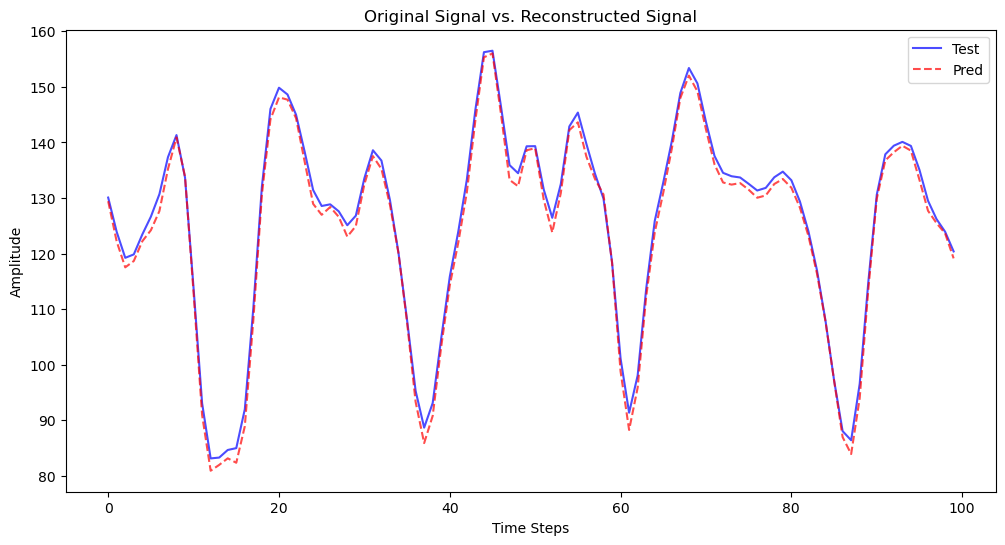

In [62]:
import matplotlib.pyplot as plt

# Assuming `signal` is the original signal and `reconstructed_signal` is the reconstructed one
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled[:100], label="Test", linewidth=1.5, alpha = 0.7, c= 'blue')
plt.plot(y_pred_rescaled[:100], label="Pred", linestyle='--', linewidth=1.5, alpha = 0.7, c ='r' )
# plt.plot(components[:,1][240 + 23:], label="ori ", linestyle='--', linewidth=1.5)
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.title("Original Signal vs. Reconstructed Signal")
plt.show()

In [156]:
components = ewt_decompose(test_df['price'], 4)

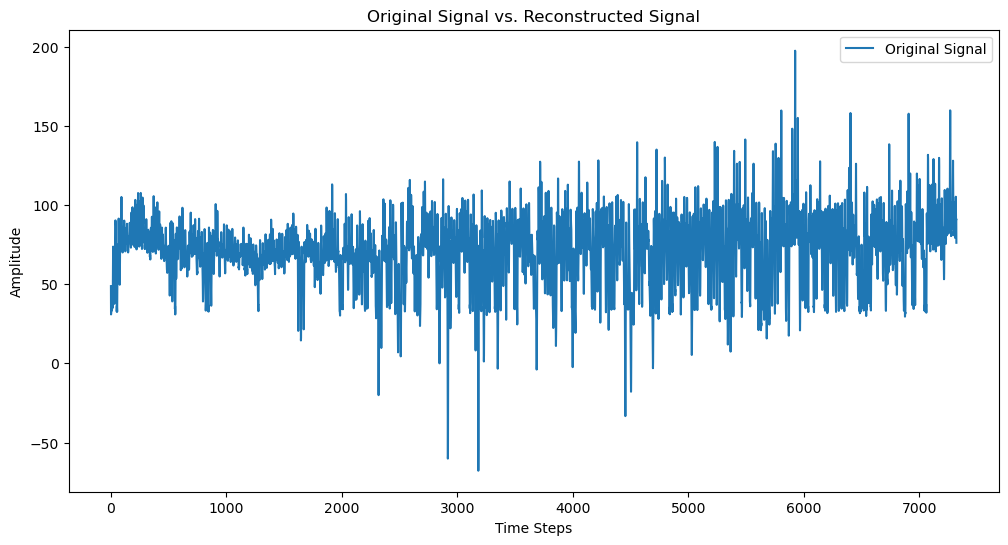

In [157]:
import matplotlib.pyplot as plt

# Assuming `signal` is the original signal and `reconstructed_signal` is the reconstructed one
plt.figure(figsize=(12, 6))
plt.plot(components[:,0], label="Original Signal", linewidth=1.5)
# plt.plot(components[0], label="Reconstructed Signal", linestyle='--', linewidth=1.5)
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.title("Original Signal vs. Reconstructed Signal")
plt.show()

In [236]:
X_test.shape

(36, 24, 1)

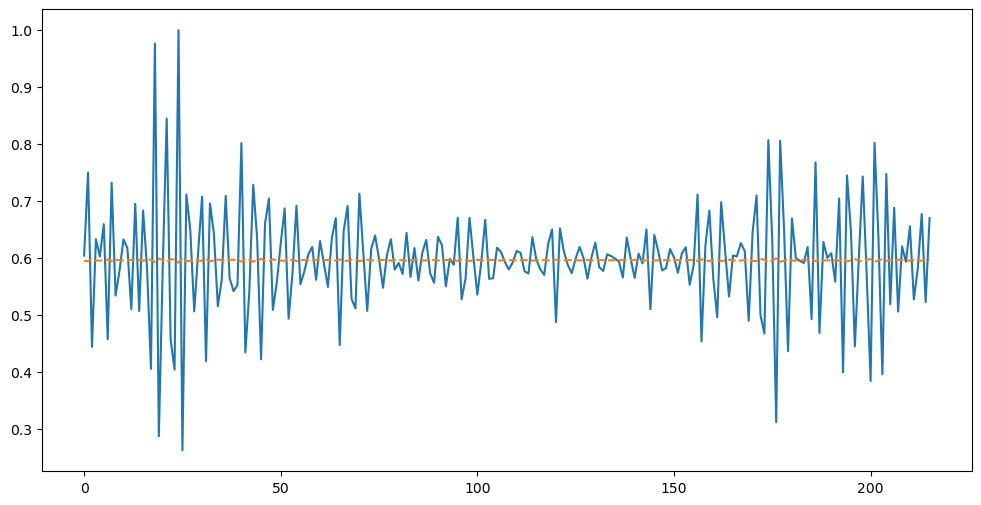

In [238]:
# Assuming `signal` is the original signal and `reconstructed_signal` is the reconstructed one
plt.figure(figsize=(12, 6))
# plt.plot(components[:,1], label="All")
plt.plot(y_train, label="Test", linewidth=1.5)
plt.plot(x_pred, label="Pred", linestyle='--', linewidth=1.5)

In [323]:
test_data.shape

(200, 1)

In [341]:

# Generate example data
data = np.sin(np.linspace(0, 100, 1000)).reshape(-1, 1)  # Example single feature time series

# Split data into training and test sets
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)  # No shuffling for time series

# Initialize the scaler and fit it only on the training data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Prepare sequences for LSTM (sequence length of 10 for example)
sequence_length = 10
X_train, y_train = [], []
X_test, y_test = [], []

# Prepare training sequences
for i in range(len(train_data_scaled) - sequence_length):
    X_train.append(train_data_scaled[i:i + sequence_length])
    y_train.append(train_data_scaled[i + sequence_length])

# Prepare test sequences
for i in range(len(test_data_scaled) - sequence_length):
    X_test.append(test_data_scaled[i:i + sequence_length])
    y_test.append(test_data_scaled[i + sequence_length])

# Convert lists to arrays and reshape for LSTM input
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build and train the LSTM model
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dense(units=1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Make predictions on the test data
y_pred_scaled = model.predict(X_test)

# Inverse transform the predictions and test targets to the original scale
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_original = scaler.inverse_transform(y_test)

# Display a few predictions vs. actual values
for i in range(10):
    print(f"Predicted: {y_pred[i][0]}, Actual: {y_test_original[i][0]}")


/Users/libin/anaconda3/envs/th/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3624 - val_loss: 0.1962
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1493 - val_loss: 0.0340
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0306 - val_loss: 0.0187
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0176 - val_loss: 0.0128
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0106 - val_loss: 0.0055
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049 - val_loss: 0.0018
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010 - val_loss: 8.4492e-04
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8698e-04 - val_loss: 8.4684e-04
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted: -0.6410661935806274, Actual: -0.5649130806946011
Predicted: -0.5575053691864014, Actual: -0.47962

In [132]:
# For multiple components
lstm_models = []
scalers = []
sequence_length = 24  # Number of previous steps to use for prediction

for i, component in enumerate(components):
    # Scale the component
    scaler = MinMaxScaler(feature_range=(0, 1))
    component_scaled = scaler.fit_transform(component.reshape(-1, 1))
    scalers.append(scaler)

    # Prepare sequences for LSTM
    X, y = [], []
    for j in range(len(component_scaled) - sequence_length):
        X.append(component_scaled[j:j + sequence_length])
        y.append(component_scaled[j + sequence_length])

    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape to 3D

    # Define LSTM model
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(X.shape[1], 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)
    lstm_models.append(model)

IndexError: tuple index out of range

### Pure EWT

In [107]:
import numpy as np
from scipy.fftpack import fft, ifft

def ewt_decompose(signal, K):
    # Perform Fourier Transform
    fourier_transform = fft(signal)
    components = []
    freq_range = np.linspace(0, np.pi, K + 1)
    
    # Define filters and extract components
    for i in range(K):
        filter_mask = np.zeros_like(fourier_transform)
        left_boundary = freq_range[i]
        right_boundary = freq_range[i + 1]
        
        for j in range(len(fourier_transform)):
            frequency = j * np.pi / len(fourier_transform)
            if left_boundary <= frequency <= right_boundary:
                filter_mask[j] = 1
        
        # Apply filter and inverse FFT
        component_fft = fourier_transform * filter_mask
        component_ifft = ifft(component_fft).real  # Convert back to time domain
        components.append(component_ifft)
    
    return np.array(components).T  # Shape: (time_steps, K components)

def ewt_reconstruct(components):
    # Sum components to reconstruct the original signal
    return np.sum(components, axis=1)

# Example usage
signal = np.sin(np.linspace(0, 10 * np.pi, 500))  # Example time series
K = 4  # Number of components
components = ewt_decompose(signal, K)

# Reconstruct the original signal
reconstructed_signal = ewt_reconstruct(components)

# Compare original and reconstructed signals
print("Original Signal:", signal[:10])
print("Reconstructed Signal:", reconstructed_signal[:10])

Original Signal: [0.         0.06291619 0.12558307 0.18775236 0.24917769 0.3096157
 0.36882689 0.42657665 0.48263615 0.53678328]
Reconstructed Signal: [-1.89060737e-04  6.28530825e-02  1.25646178e-01  1.87941418e-01
  2.48988634e-01  3.09552593e-01  3.68889991e-01  4.26765709e-01
  4.82447094e-01  5.36720173e-01]


In [109]:
abs(signal -reconstructed_signal).sum()

0.06304108219883488